In [12]:
# Author: Xavier Tidus Hutchinson
# University: UNSW Australian Defence Force Academy, Canberra ACT, AU.
# Licence: My work is free for all to use. Other licences may apply.
#
# Special Thanks & Recognition: 
# This notebook leverages the fantastic work and research of UNB and requries their published
# CICMalDroid2020 Datasets to function.
#
# You can request access to your own copies by visiting their website here: https://www.unb.ca/cic/datasets/maldroid-2020.html
#
# Please credit the authors in your work and maintain refrences.
#
#
# Be careful, all sense of safety is an illiusion. 
# It's a wild world.

In [13]:
import os
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import shutil
import random
import subprocess
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer

# Directory setup from previous code
dir_working_path_root = os.path.expanduser("~/tmp")
dir_source_apk_path_root = os.path.join(dir_working_path_root, "source-apks")
dir_apk_working_path_root = os.path.join(dir_working_path_root, "ngram-working")

dir_malicious_source_apks = os.path.join(dir_source_apk_path_root, "malware_extracted")
dir_malicious_working_apks = os.path.join(dir_apk_working_path_root, "working", "malicious", "apks")
dir_malicious_working_decompiled = os.path.join(dir_apk_working_path_root, "working", "malicious", "decompiled")

dir_benign_source_apks = os.path.join(dir_source_apk_path_root, "benign_extracted")
dir_benign_working_apks = os.path.join(dir_apk_working_path_root, "working", "benign", "apks")
dir_benign_working_decompiled = os.path.join(dir_apk_working_path_root, "working", "benign", "decompiled")

dir_malicious_source_apks_adware = os.path.join(dir_malicious_source_apks, "adware")
dir_malicious_source_apks_banking = os.path.join(dir_malicious_source_apks, "banking")
dir_malicious_source_apks_riskware = os.path.join(dir_malicious_source_apks, "riskware")
dir_malicious_source_apks_sms2 = os.path.join(dir_malicious_source_apks, "sms")

include_banking_in_sample = True
include_adware_in_sample = True
include_riskware_in_sample = True
include_sms2_in_sample = True

# Function to get the number of files in a directory
def count_files_in_dir(directory):
    if not os.path.exists(directory):
        return 0
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

# Function to calculate weighted sample sizes for malware types
def get_weighted_malware_samples(target_sample_size):
    # Count files in each malware directory
    counts = {}
    if include_adware_in_sample:
        counts['adware'] = count_files_in_dir(dir_malicious_source_apks_adware)
    if include_banking_in_sample:
        counts['banking'] = count_files_in_dir(dir_malicious_source_apks_banking)
    if include_riskware_in_sample:
        counts['riskware'] = count_files_in_dir(dir_malicious_source_apks_riskware)
    if include_sms2_in_sample:
        counts['sms2'] = count_files_in_dir(dir_malicious_source_apks_sms2)
    
    total_files = sum(counts.values())
    if total_files == 0:
        print("No files found in any selected malware directories.")
        return {}
    
    # Calculate weighted sample sizes
    weighted_samples = {}
    remaining_samples = target_sample_size
    
    for category, count in counts.items():
        if count == 0:
            weighted_samples[category] = 0
            continue
        # Proportion based on file count
        proportion = count / total_files
        sample_size = int(round(proportion * target_sample_size))
        weighted_samples[category] = min(sample_size, count, remaining_samples)
        remaining_samples -= weighted_samples[category]
    
    # Distribute any remaining samples to categories with files
    while remaining_samples > 0 and any(count > weighted_samples[cat] for cat, count in counts.items()):
        for category in counts:
            if remaining_samples == 0:
                break
            if counts[category] > weighted_samples[category]:
                weighted_samples[category] += 1
                remaining_samples -= 1
    
    return weighted_samples

# Function to get all files in a directory
def get_files_in_dir(directory):
    return [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

# Function to copy random sample of files
def copy_random_sample(source_dir, dest_dir, sample_size, dir_name):
    if not os.path.exists(source_dir):
        print(f"Source directory {source_dir} does not exist!")
        return
    
    files = get_files_in_dir(source_dir)
    total_files = len(files)
    
    if total_files == 0:
        print(f"No files found in {source_dir}")
        return
    
    if sample_size > total_files:
        print(f"Requested sample size ({sample_size}) exceeds available files ({total_files}) in {dir_name}. Using all available files.")
        sample_size = total_files
    
    # Randomly select files
    selected_files = random.sample(files, sample_size)
    
    # Copy selected files to destination
    for file_name in selected_files:
        src_path = os.path.join(source_dir, file_name)
        dst_path = os.path.join(dest_dir, file_name)
        shutil.copy2(src_path, dst_path)
    print(f"Copied {len(selected_files)} files from {dir_name} to {dest_dir}")

def extract_apk(apk_path, output_dir):
    # Build apktool command
    command = ["apktool", "d", apk_path, "-o", output_dir]
    
    try:
        # Run the command
        result = subprocess.run(command, capture_output=True, text=True, check=True)
        print(f"Successfully decompiled {apk}:\n")
        if result.stderr:
            print(f"Warnings for {apk}:\n")
    except subprocess.CalledProcessError as e:
        print(f"Failed to decompile {apk}:\n")
    except FileNotFoundError:
        print("apktool not found. Ensure it is installed and in PATH.")



In [14]:
def extract_smali(input_dir, output_file):
    """
    Extract Smali code from decompiled .apk files into a single text file.
    """
    if not os.path.exists(input_dir):
        raise FileNotFoundError(f"Directory {input_dir} does not exist.")
    
    with open(output_file, 'w', encoding='utf-8', errors='ignore') as outfile:
        smali_files = glob.glob(f"{input_dir}/**/smali/**/*.smali", recursive=True)
        if not smali_files:
            raise FileNotFoundError(f"No .smali files found in {input_dir}")
        
        for smali_file in smali_files:
            with open(smali_file, 'r', encoding='utf-8', errors='ignore') as infile:
                outfile.write(infile.read() + '\n')
    
    print(f"Smali code extracted to {output_file}")

def generate_ngram_data(benign_smali_file, malicious_smali_file, output_npz='ngram_data.npz', ngram_size=3):
    """
    Generate n-gram frequency data from Smali code with fixed tokenizer.
    """
    def smali_tokenizer(text):
        # Fixed tokenizer: single group regex to avoid tuples
        # Capture Smali keywords, registers, and identifiers
        tokens = re.findall(r'\b(?:invoke|move|iget|iput|const|goto|if|return|new|array|fill|throw|monitor|check|instance|static|field|method|object|virtual|direct|interface|super|constructor|range|quick|v[0-9]+|[a-zA-Z0-9_\-\./:]+)\b', text.lower())
        return tokens  # Returns list of strings

    def clean_text(text):
        text = re.sub(r'[\x00-\x1F\x7F-\xFF]', ' ', text)  # Replace control chars
        text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
        return text.strip()

    if not os.path.exists(benign_smali_file):
        raise FileNotFoundError(f"File {benign_smali_file} does not exist.")
    if not os.path.exists(malicious_smali_file):
        raise FileNotFoundError(f"File {malicious_smali_file} does not exist.")
    
    with open(benign_smali_file, 'r', encoding='utf-8', errors='ignore') as f:
        benign_text = [clean_text(f.read())]
    with open(malicious_smali_file, 'r', encoding='utf-8', errors='ignore') as f:
        malicious_text = [clean_text(f.read())]
    
    # Use custom tokenizer
    vectorizer_custom = CountVectorizer(analyzer='word', ngram_range=(ngram_size, ngram_size), tokenizer=smali_tokenizer)
    X_custom = vectorizer_custom.fit_transform(benign_text + malicious_text)
    ngrams_custom = vectorizer_custom.get_feature_names_out()
    benign_counts_custom = X_custom[0].toarray().flatten()
    malicious_counts_custom = X_custom[1].toarray().flatten()
    
    if len(ngrams_custom) < 50:
        print("Warning: Custom tokenizer yielded insufficient n-grams. Falling back to raw tokenizer.")
        vectorizer_raw = CountVectorizer(analyzer='word', ngram_range=(ngram_size, ngram_size), token_pattern=r'\S+')
        X_raw = vectorizer_raw.fit_transform(benign_text + malicious_text)
        ngrams = vectorizer_raw.get_feature_names_out()
        benign_counts = X_raw[0].toarray().flatten()
        malicious_counts = X_raw[1].toarray().flatten()
    else:
        ngrams = ngrams_custom
        benign_counts = benign_counts_custom
        malicious_counts = malicious_counts_custom
    
    total_counts = benign_counts + malicious_counts
    top_indices = np.argsort(total_counts)[::-1][:10]
    print("Top 10 n-grams and total counts:", list(zip(ngrams[top_indices], total_counts[top_indices])))
    
    np.savez(output_npz, ngrams=ngrams, benign=benign_counts, malicious=malicious_counts)
    print(f"N-gram data saved to {output_npz}")

def plot_ngram_frequency(data_path, output_path='ngram_frequency.png', top_n=50, 
                        benign_color='#1f77b4', malicious_color='#ff7f0e', dpi=300):
    """
    Plot N-Gram Frequency Distribution for benign vs. malicious Android apps.
    """
    data = np.load(data_path, allow_pickle=True)
    ngrams = data['ngrams']
    benign_counts = data['benign']
    malicious_counts = data['malicious']
    
    total_counts = benign_counts + malicious_counts
    if len(ngrams) < top_n or np.all(total_counts == 0):
        print(f"Warning: Insufficient data. Found {len(ngrams)} n-grams, all counts are {total_counts[:10]}")
        return
    
    sort_indices = np.argsort(total_counts)[::-1][:top_n]
    ngrams = ngrams[sort_indices]
    benign_counts = benign_counts[sort_indices]
    malicious_counts = malicious_counts[sort_indices]
    
    x = np.arange(len(ngrams))
    width = 0.35

    fig, ax = plt.subplots(figsize=(15, 9))
    ax.bar(x - width/2, benign_counts, width, label='Benign', color=benign_color)
    ax.bar(x + width/2, malicious_counts, width, label='Malicious', color=malicious_color)
    
    ax.set_xlabel('N-Grams')
    ax.set_ylabel('Frequency')
    ax.set_title('Top 50 3-Gram Frequency Distribution in Benign vs. Malicious Apps')
    ax.set_xticks(x)
    ax.set_xticklabels(ngrams, rotation=90)
    ax.legend()
    
    ax.set_ylim(bottom=0, top=max(benign_counts.max(), malicious_counts.max()) * 1.1)
    
    description = (
        "Xavier Hutchinson (z5626926) ZEIT8025 Research Project 2025 S1. Generated using Matplotlib 3.5.1 "
        "in Python on macOS. Decompiled .apk files were processed to extract 3-grams using CountVectorizer. "
        "Frequencies of top 50 3-grams in benign vs. malicious apps were plotted as a bar chart, highlighting "
        "distinct patterns (e.g., higher network call n-grams in malicious apps)."
    )
    plt.figtext(0.5, -0.1, description, wrap=True, horizontalalignment='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=dpi, bbox_inches='tight')
    plt.show()
    print(f"Plot saved to {output_path}")

def generate_table1_text(data_path, top_n=3, min_diff=0.0001):
    """
    Generate text data for Table 1 based on the top n-grams with significant frequency differences.
    """
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file {data_path} does not exist.")
    
    data = np.load(data_path, allow_pickle=True)
    ngrams = data['ngrams']
    benign_counts = data['benign']
    malicious_counts = data['malicious']
    
    total_counts = benign_counts + malicious_counts
    freq_diff = malicious_counts - benign_counts  # Positive for malicious dominance, negative for benign
    
    # Top malicious n-grams (where malicious frequency is higher)
    malicious_indices = np.argsort(freq_diff)[::-1][:top_n * 2]  # Look at top candidates
    malicious_top = [(ngrams[i], benign_counts[i], malicious_counts[i]) 
                     for i in malicious_indices if freq_diff[i] > min_diff]
    if len(malicious_top) < top_n:
        print(f"Warning: Found only {len(malicious_top)} malicious-dominant n-grams, padding with zeros.")
        # Fallback to top by total count with positive difference
        top_total_indices = np.argsort(total_counts)[::-1][:top_n * 2]
        malicious_top = [(ngrams[i], benign_counts[i], malicious_counts[i]) 
                        for i in top_total_indices if freq_diff[i] > 0][:top_n]
        if len(malicious_top) < top_n:
            malicious_top.extend([('', 0, 0)] * (top_n - len(malicious_top)))
    malicious_top = malicious_top[:top_n]
    
    # Top benign n-grams (where benign frequency is higher)
    benign_indices = np.argsort(freq_diff)[:top_n * 2]  # Lowest differences (negative)
    benign_top = [(ngrams[i], benign_counts[i], malicious_counts[i]) 
                  for i in benign_indices if freq_diff[i] < -min_diff]
    if len(benign_top) < top_n:
        print(f"Warning: Found only {len(benign_top)} benign-dominant n-grams, padding with zeros.")
        # Fallback to top by total count with negative difference
        top_total_indices = np.argsort(total_counts)[::-1][:top_n * 2]
        benign_top = [(ngrams[i], benign_counts[i], malicious_counts[i]) 
                     for i in top_total_indices if freq_diff[i] < 0][:top_n]
        if len(benign_top) < top_n:
            benign_top.extend([('', 0, 0)] * (top_n - len(benign_top)))
    benign_top = benign_top[:top_n]
    
    # Format table text
    table_text = "**Table 1: Top 3 N-Grams by Frequency**\n\n"
    table_text += "| N-Gram       | Benign Frequency | Malicious Frequency |\n"
    table_text += "|--------------|------------------|---------------------|\n"
    for ngram, benign_freq, mal_freq in malicious_top:
        table_text += f"| {ngram:<12} | {benign_freq:>14.4f} | {mal_freq:>17.4f} |\n"
    for ngram, benign_freq, mal_freq in benign_top:
        table_text += f"| {ngram:<12} | {benign_freq:>14.4f} | {mal_freq:>17.4f} |\n"
    table_text += "*Note*: Frequencies are normalized counts based on dataset size.\n"
    
    print("Top malicious n-grams:", malicious_top)
    print("Top benign n-grams:", benign_top)
    
    return table_text

In [15]:
# Print file counts for source directories
fc_benign = count_files_in_dir(dir_benign_source_apks)
fc_mal_adware = count_files_in_dir(dir_malicious_source_apks_adware)
fc_mal_banking = count_files_in_dir(dir_malicious_source_apks_banking)
fc_mal_riskware = count_files_in_dir(dir_malicious_source_apks_riskware)
fc_mal_sms2 = count_files_in_dir(dir_malicious_source_apks_sms2)

print(f"Number of files in benign source: {fc_benign}")
if include_adware_in_sample:
    print(f"Number of files in malware/adware source: {fc_mal_adware}")
if include_banking_in_sample:
    print(f"Number of files in malware/banking source: {fc_mal_banking}")
if include_riskware_in_sample:
    print(f"Number of files in malware/riskware source: {fc_mal_riskware}")
if include_sms2_in_sample:
    print(f"Number of files in malware/sms2 source: {fc_mal_sms2}")

Number of files in benign source: 4042
Number of files in malware/adware source: 1515
Number of files in malware/banking source: 2506
Number of files in malware/riskware source: 4362
Number of files in malware/sms2 source: 4822


In [16]:
# Verify directories
print("The following map of directories will be used:")
print(f"\t- Sample Output Directories:")
print(f"\t\t- Benign APKs: {dir_benign_working_apks}")
print(f"\t\t- Malware APKs: {dir_malicious_working_apks}")
print(f"\t\t  (Selected malware are combined beyond this step)")

The following map of directories will be used:
	- Sample Output Directories:
		- Benign APKs: /Users/xavier/tmp/ngram-working/working/benign/apks
		- Malware APKs: /Users/xavier/tmp/ngram-working/working/malicious/apks
		  (Selected malware are combined beyond this step)


In [17]:
# create directories
Path(dir_apk_working_path_root).mkdir(parents=True, exist_ok=True)
if os.path.exists(dir_apk_working_path_root):
    shutil.rmtree(dir_apk_working_path_root)
    os.makedirs(dir_apk_working_path_root)

Path(dir_benign_working_apks).mkdir(parents=True, exist_ok=True)
Path(dir_malicious_working_apks).mkdir(parents=True, exist_ok=True)

In [18]:
# Please select your sample size.
benign_sample_size = 10
malicious_sample_size = 25

# This is the amount of benign and the appropriately weighted (by representation) amounts of malware.
# A value of 100 for example, will copy 100 random benign apks for analysis, but will also copy 100 malware apks.
# If adware has 400 files, banking has 300, riskware has 200, sms2 has 100 (total 1000 files), and target_sample_size is 100:
# Proportions: adware (40%), banking (30%), riskware (20%), sms2 (10%).
# Initial allocation: adware (40), banking (30), riskware (20), sms2 (10).
# If rounding causes a shortfall (e.g., 99 samples allocated), the remaining 1 sample is given to a category with available files.
try:
    if benign_sample_size < 0:
        raise ValueError("Sample size cannot be negative")
    
    if malicious_sample_size < 0:
        raise ValueError("Sample size cannot be negative")
        
except ValueError as e:
    print(f"Invalid input: {e}. Please enter positive integers.")

# Get weighted sample sizes for malicious files
weighted_samples = get_weighted_malware_samples(malicious_sample_size)
if not weighted_samples:
    print("No malicious samples to process.")

# Sample malicious files based on weighted counts
dir_mapping = {
    'adware': dir_malicious_source_apks_adware,
    'banking': dir_malicious_source_apks_banking,
    'riskware': dir_malicious_source_apks_riskware,
    'sms2': dir_malicious_source_apks_sms2
}

print("Malware weighted allocation plan:")
for category, sample_size in weighted_samples.items():
    print(f"\t{category}: {sample_size}")

Malware weighted allocation plan:
	adware: 3
	banking: 5
	riskware: 8
	sms2: 9


In [19]:
# Sample benign files
copy_random_sample(dir_benign_source_apks, dir_benign_working_apks, benign_sample_size, "benign")

for category, sample_size in weighted_samples.items():
    if sample_size > 0:
        copy_random_sample(dir_mapping[category], dir_malicious_working_apks, sample_size, "malicious")
    else:
        print(f"Skipping {category} (no samples allocated or no files available)")

Copied 10 files from benign to /Users/xavier/tmp/ngram-working/working/benign/apks
Copied 3 files from malicious to /Users/xavier/tmp/ngram-working/working/malicious/apks
Copied 5 files from malicious to /Users/xavier/tmp/ngram-working/working/malicious/apks
Copied 8 files from malicious to /Users/xavier/tmp/ngram-working/working/malicious/apks
Copied 9 files from malicious to /Users/xavier/tmp/ngram-working/working/malicious/apks


In [20]:
malicious_apk_files = Path(dir_malicious_working_apks).glob("*.apk")
benign_apk_files = Path(dir_benign_working_apks).glob("*.apk")

for apk in malicious_apk_files:
    extract_apk(apk, f"{dir_malicious_working_decompiled}/{apk.stem}")

for apk in benign_apk_files:
    extract_apk(apk, f"{dir_benign_working_decompiled}/{apk.stem}")


Successfully decompiled /Users/xavier/tmp/ngram-working/working/malicious/apks/274cc0b1aabea474d00df33de90bb527.apk:

Successfully decompiled /Users/xavier/tmp/ngram-working/working/malicious/apks/d6027dd11e47f4ecbc0606fb2fd08453.apk:

Successfully decompiled /Users/xavier/tmp/ngram-working/working/malicious/apks/122de0c25d4dea5c49bffad02798165b52955395ef10d25032403a02a9421213.apk:

Warnings for /Users/xavier/tmp/ngram-working/working/malicious/apks/122de0c25d4dea5c49bffad02798165b52955395ef10d25032403a02a9421213.apk:

Successfully decompiled /Users/xavier/tmp/ngram-working/working/malicious/apks/abb167e491984b6beb07eb16a500b59ba652145a3d5b3b413439a8ee085380be.apk:

Successfully decompiled /Users/xavier/tmp/ngram-working/working/malicious/apks/6ccd6c609b4efa703a1c30ba95f2b2ca.apk:

Failed to decompile /Users/xavier/tmp/ngram-working/working/malicious/apks/b3586ffc5e4976f1e6a976d21f63322d.apk:

Successfully decompiled /Users/xavier/tmp/ngram-working/working/malicious/apks/5163f5d85a3ae3

In [21]:
# Perform the extraction of our smali code for malicious and bengin
extract_smali(dir_malicious_working_decompiled, f"{dir_apk_working_path_root}/malicioius_smali.txt")
extract_smali(dir_benign_working_decompiled, f"{dir_apk_working_path_root}/benign_smali.txt")

Smali code extracted to /Users/xavier/tmp/ngram-working/malicioius_smali.txt
Smali code extracted to /Users/xavier/tmp/ngram-working/benign_smali.txt


In [22]:
# generate ngram
generate_ngram_data(f"{dir_apk_working_path_root}/benign_smali.txt", f"{dir_apk_working_path_root}/malicioius_smali.txt", f'{dir_apk_working_path_root}/ngram_data.npz')

/Users/xavier/projects/ZEIT8025-z5626926-062025-researchProject/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top 10 n-grams and total counts: [('end method method', np.int64(273851)), ('-object v0 p0', np.int64(265132)), ('iget -object v0', np.int64(247518)), ('method method public', np.int64(204301)), ('move -result-object v0', np.int64(177738)), ('invoke -virtual v0', np.int64(165347)), ('return -void end', np.int64(140723)), ('-void end method', np.int64(140477)), ('iget -object v1', np.int64(139195)), ('-object v1 p0', np.int64(138626))]
N-gram data saved to /Users/xavier/tmp/ngram-working/ngram_data.npz


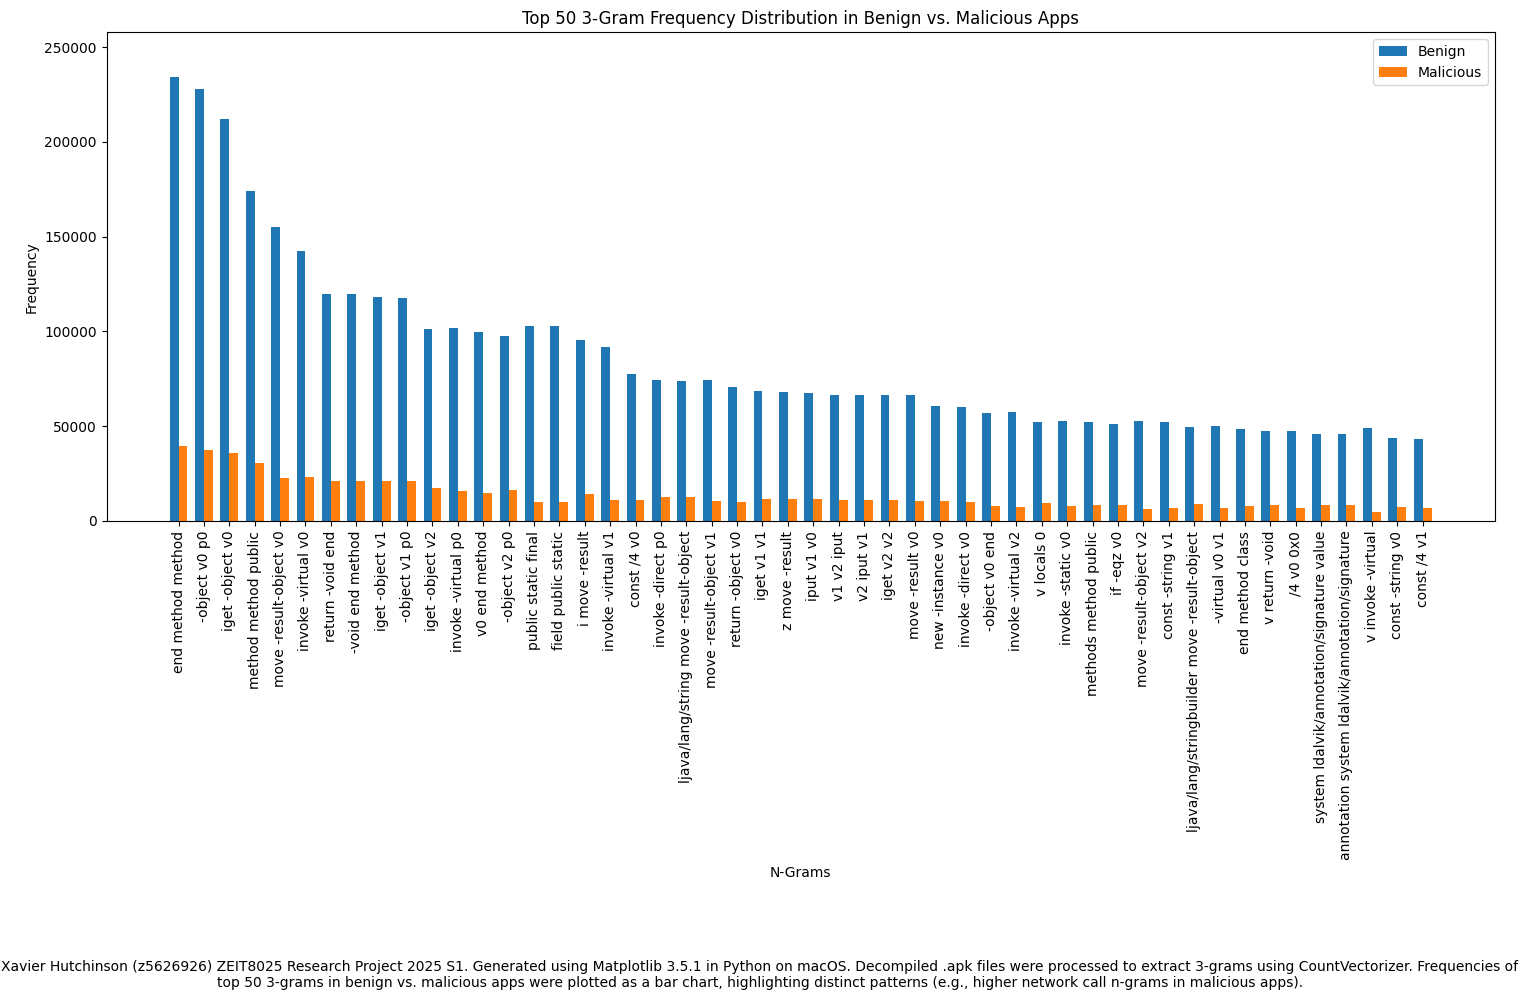

Plot saved to /Users/xavier/tmp/ngram-working/ngram_frequency.png


In [23]:
# Plot the ngram data
plot_ngram_frequency(f'{dir_apk_working_path_root}/ngram_data.npz', f'{dir_apk_working_path_root}/ngram_frequency.png')

In [24]:
# Generate and print Table 1 text
table1_text = generate_table1_text(f'{dir_apk_working_path_root}/ngram_data.npz', 10)
print(table1_text)

Top malicious n-grams: [('v1 v1 lcom/google/android/gms/internal/zzbx', np.int64(0), np.int64(11260)), ('zzagf:lcom/google/android/gms/internal/zzbx iget v1', np.int64(0), np.int64(11260)), ('v1 v0 lcom/google/android/gms/internal/zzbx', np.int64(0), np.int64(11068)), ('zzagf:lcom/google/android/gms/internal/zzbx iget -object', np.int64(0), np.int64(11004)), ('v2 v2 lcom/google/android/gms/internal/zzbx', np.int64(0), np.int64(10974)), ('zzagf:lcom/google/android/gms/internal/zzbx iget v2', np.int64(0), np.int64(10974)), ('p0 lcom/google/android/gms/internal/zzcf zzagf:lcom/google/android/gms/internal/zzbx', np.int64(0), np.int64(3001)), ('p0 lcom/google/android/gms/internal/zzch zzagf:lcom/google/android/gms/internal/zzbx', np.int64(0), np.int64(3001)), ('p0 lcom/google/android/gms/internal/zzci zzagf:lcom/google/android/gms/internal/zzbx', np.int64(0), np.int64(3001)), ('p0 lcom/google/android/gms/internal/zzce zzagf:lcom/google/android/gms/internal/zzbx', np.int64(0), np.int64(3001)